# AID - Aerial Scene Classification
Amaç: Hava/uydu görüntülerinden sahne tipi tahmini (30 sınıf).
Veri: AID dataset (Kaggle / HuggingFace)


In [7]:
# Hücre 2 - Kütüphaneler
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-09-20 18:54:10.976231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758394451.346349      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758394451.455607      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
!ls /kaggle/input

aid-scene-classification-datasets


In [9]:
# Dataset yolunu ayarla
base_path = "/kaggle/input/aid-scene-classification-datasets/AID"

# İçerikleri listele
print("Dataset içeriği:", os.listdir(base_path))

Dataset içeriği: ['Mountain', 'Airport', 'Park', 'River', 'DenseResidential', 'StorageTanks', 'Church', 'BaseballField', 'Parking', 'Square', 'Industrial', 'RailwayStation', 'SparseResidential', 'MediumResidential', 'Viaduct', 'Pond', 'Center', 'Port', 'BareLand', 'Bridge', 'Resort', 'Beach', 'Meadow', 'Farmland', 'Desert', 'Stadium', 'Forest', 'Commercial', 'School', 'Playground']


In [10]:
# Dataset içindeki sınıfları listele
classes = os.listdir(base_path)
print("Sınıf sayısı:", len(classes))
print("Sınıflar:", classes[:10])  # ilk 10 sınıfı göster

Sınıf sayısı: 30
Sınıflar: ['Mountain', 'Airport', 'Park', 'River', 'DenseResidential', 'StorageTanks', 'Church', 'BaseballField', 'Parking', 'Square']


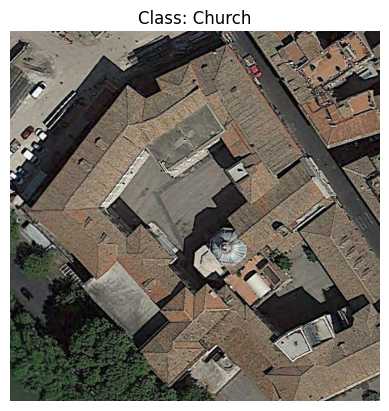

In [11]:
import random
import matplotlib.image as mpimg

# Rastgele bir sınıf seç
sample_class = random.choice(classes)
sample_folder = os.path.join(base_path, sample_class)
sample_image = random.choice(os.listdir(sample_folder))

img_path = os.path.join(sample_folder, sample_image)
img = mpimg.imread(img_path)

plt.imshow(img)
plt.title(f"Class: {sample_class}")
plt.axis("off")
plt.show()

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# %80 train / %20 validation split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    base_path,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    base_path,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

class_indices = train_gen.class_indices
print("Sınıflar:", class_indices)

Found 8000 images belonging to 30 classes.
Found 2000 images belonging to 30 classes.
Sınıflar: {'Airport': 0, 'BareLand': 1, 'BaseballField': 2, 'Beach': 3, 'Bridge': 4, 'Center': 5, 'Church': 6, 'Commercial': 7, 'DenseResidential': 8, 'Desert': 9, 'Farmland': 10, 'Forest': 11, 'Industrial': 12, 'Meadow': 13, 'MediumResidential': 14, 'Mountain': 15, 'Park': 16, 'Parking': 17, 'Playground': 18, 'Pond': 19, 'Port': 20, 'RailwayStation': 21, 'Resort': 22, 'River': 23, 'School': 24, 'SparseResidential': 25, 'Square': 26, 'Stadium': 27, 'StorageTanks': 28, 'Viaduct': 29}


In [14]:
from tensorflow.keras import Input

model = models.Sequential([
    Input(shape=(128,128,3)),     # İlk katmanı Input olarak verdik
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 👇 Bu satır olmazsa ekrana hiçbir şey basmaz
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,308,510 (12.62 MB)

 Trainable params: 3,308,510 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,   # hızlı deneme için 5, sonra 15-20 yapabilirsin
    steps_per_epoch=50,
    validation_steps=10
)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 269ms/step - accuracy: 0.4667 - loss: 1.7113 - val_accuracy: 0.5063 - val_loss: 1.7041
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 265ms/step - accuracy: 0.4798 - loss: 1.6955 - val_accuracy: 0.4688 - val_loss: 1.7721
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 251ms/step - accuracy: 0.5089 - loss: 1.5904 - val_accuracy: 0.4500 - val_loss: 1.7589
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 234ms/step - accuracy: 0.5221 - loss: 1.5839 - val_accuracy: 0.4812 - val_loss: 1.6248
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - accuracy: 0.4902 - loss: 1.6412 - val_accuracy: 0.5000 - val_loss: 1.6016


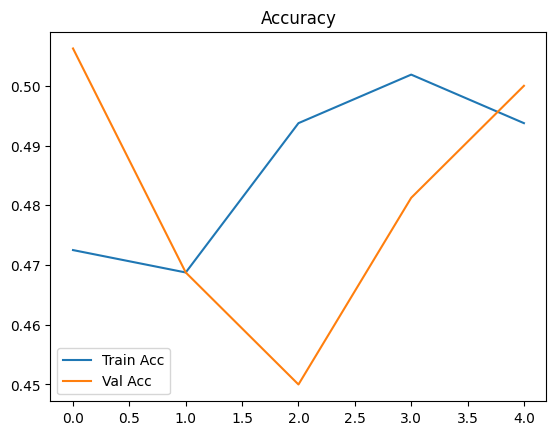

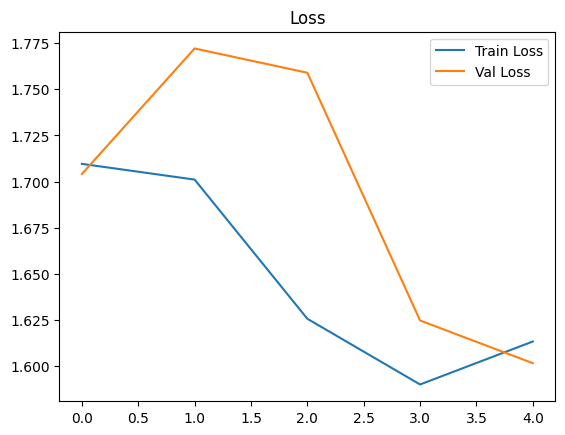

63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 241ms/step


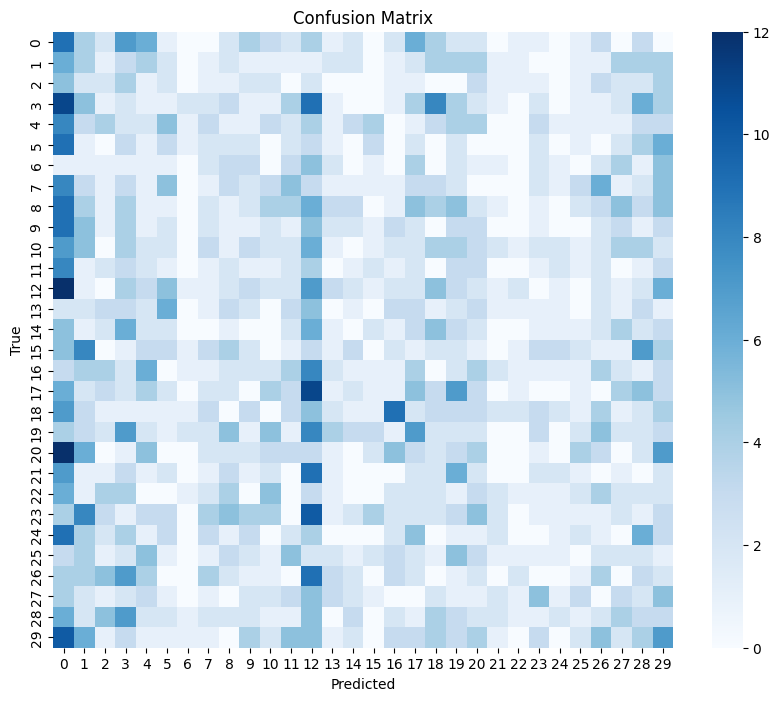

                   precision    recall  f1-score   support

          Airport       0.05      0.12      0.07        72
         BareLand       0.04      0.06      0.05        62
    BaseballField       0.04      0.05      0.04        44
            Beach       0.02      0.03      0.02        80
           Bridge       0.03      0.03      0.03        72
           Center       0.05      0.06      0.05        52
           Church       0.00      0.00      0.00        48
       Commercial       0.02      0.01      0.02        70
 DenseResidential       0.02      0.01      0.01        82
           Desert       0.02      0.02      0.02        60
         Farmland       0.04      0.03      0.03        74
           Forest       0.03      0.04      0.03        50
       Industrial       0.04      0.09      0.06        78
           Meadow       0.00      0.00      0.00        56
MediumResidential       0.00      0.00      0.00        58
         Mountain       0.00      0.00      0.00       

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# -----------------------------
# 1) Accuracy & Loss Grafikleri
# -----------------------------
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()


# -----------------------------
# 2) Confusion Matrix & Report
# -----------------------------
# Tahminleri al
y_true = val_gen.classes
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification report
print(classification_report(
    y_true, 
    y_pred, 
    target_names=list(val_gen.class_indices.keys()), 
    zero_division=0
))

In [29]:
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {val_acc:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.5245 - loss: 1.6046
Validation Accuracy: 0.52


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


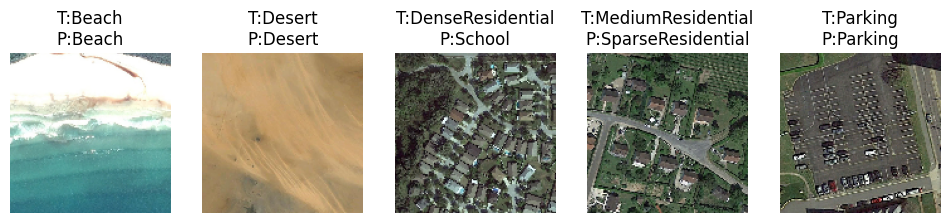

In [30]:
import numpy as np

# Validation setinden bir batch al
sample_batch, sample_labels = next(val_gen)

# İlk 5 görüntü için tahmin yap
preds = model.predict(sample_batch[:5])
pred_classes = np.argmax(preds, axis=1)

plt.figure(figsize=(12,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(sample_batch[i])
    plt.axis("off")
    true_label = list(class_indices.keys())[np.argmax(sample_labels[i])]
    pred_label = list(class_indices.keys())[pred_classes[i]]
    plt.title(f"T:{true_label}\nP:{pred_label}")
plt.show()